In [1]:
import keras
keras.__version__

'3.8.0'

# Classification of newswires: an example of multiclass classification

This notebook contains code samples found in Chapter 3, Section 5 of the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text contains much more content, especially additional explanations and images: in this notebook you will find only the source code and related comments.

----

In the previous section we saw how vector inputs are classified into two mutually exclusive classes using a densely connected neural network. But what happens when you have more than two classes?

In this section we'll build a network to classify Reuters newswires into 46 different mutually exclusive topics. Since we have many classes, this problem is an example of "multiclass classification", and since each data point should be classified into only one category, the problem is more precisely an example of "single-label, multiclass classification". If each data point could belong to multiple categories (in our case, topics), then we would be dealing with a "multi-label, multiclass classification" problem.

##  Reuters dataset

We'll work with the Reuters dataset, a set of short newswires and their topics published by Reuters in 1986. It's a very simple, widely used "toy" dataset for text classification. There are 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset is packaged as part of Keras. Let's take a look at it now:

In [2]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


The topic is determined using the words; there are many topics.

As with the IMDB dataset, the `num_words=10000` argument limits the data to the 10,000 most frequently used words found in the dataset.

We have 8,982 training samples and 2,246 test samples:

In [3]:
len(train_data)

8982

In [4]:
len(test_data)

2246

As with the IMDB reviews, each example is a list of integers (word indices):

In [5]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

Here's how you can decode it back into words, in case you're curious:

In [6]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
decoded_newswire

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

The label associated with the example is an integer between 0 and 45 - the topic index.

In [8]:
import numpy as np
np.unique(train_labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

## Data preparation

We can vectorize the data using exactly the same code as in our previous example:

In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

In [ ]:
x_train.shape #8982 number of articles in the training set, 10,000 is the number of words in terms of zeros and ones, 1 where the word appears in the article

(8982, 10000)

In [ ]:
train_labels.shape #in the sense that 8982 is the number of rows and there is one column which is actually a list of elements and not a specific element, so it does not say (8982,1) but after the comma it does not say anything
#probably this shape cannot conclude that it is one element and that it is a list

(8982,)

To vectorize the labels, there are two options: we could simply convert the list of labels into an integer tensor, or we could use "one-of-N" (one-hot) encoding. One-hot encoding is a widely used format for categorical data, also called "categorical encoding".
For a more detailed explanation of one-hot encoding, refer to Chapter 6, Section 1.
In our case, the one-hot encoding of our labels consists of embedding each label as a full zero vector with a 1 at the index of the label, e.g.:

We want to have a multi-output case where the output is an array of length 45 for each article, and for each input sample we will have an array that tells which article the input sample belongs to.

In [ ]:
def to_one_hot(labels, dimension=46):  #this part converts the list into a vector of length 46 where there is a one only at the position of the class to which the text belongs
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# Our vectorized training labels
one_hot_train_labels = to_one_hot(train_labels)
# Our vectorized test labels
one_hot_test_labels = to_one_hot(test_labels)

Note that there is a built-in way to do this in Keras, which you have already seen in the MNIST example:

In [ ]:
from keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels) #convert both training labels and test labels into vectors
one_hot_test_labels = to_categorical(test_labels)

In [14]:
one_hot_test_labels.shape

(2246, 46)

## Building our network

This topic classification problem looks very similar to our previous movie review classification problem: in both cases we are trying to classify short pieces of text. However, there is a new constraint: the number of output classes has grown from 2 to 46, i.e. the dimensionality of the output space is much larger.

In a stack of `Dense` layers, each layer can only access information present in the output of the previous layer. If a layer drops some information relevant to the classification task, that information can never be recovered by later layers: each layer can potentially become an information bottleneck. In our previous example we used 16-dimensional intermediate layers, but a 16-dimensional space may be too limited to learn to separate 46 different classes — such small layers can act as information bottlenecks, permanently discarding relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [ ]:
from keras import models #again we define the model, 10000 nodes at the input
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) #at the output we have 46 nodes for 46 articles and the node will be 1 where the neural network thinks the solution is, i.e. where that article is, usually there are not 0s and 1s but numbers from 0 to 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


There are two more things to notice about this architecture:

* We finish the network with a `Dense` layer of size 46. This means that for each input sample our network will output a 46-dimensional vector. Each entry in this vector corresponds to a different output class.
* The final layer uses a `softmax` activation. You saw this pattern in the MNIST example: the network outputs a probability distribution over the 46 output classes — for each input sample the network produces a 46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: in our case, between the probability distribution produced by the network and the true label distribution. By minimizing the distance between these distributions, we train the network to produce outputs as close as possible to the true labels.

In [16]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Validation of our approach

Let's set aside 1,000 samples from our training data to use as a validation set:

In [17]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [18]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.4425 - loss: 3.0496 - val_accuracy: 0.6500 - val_loss: 1.6664
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6895 - loss: 1.4852 - val_accuracy: 0.7080 - val_loss: 1.3245
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7463 - loss: 1.1468 - val_accuracy: 0.7440 - val_loss: 1.1852
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7966 - loss: 0.9499 - val_accuracy: 0.7570 - val_loss: 1.0916
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8253 - loss: 0.8147 - val_accuracy: 0.7870 - val_loss: 1.0155
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8565 - loss: 0.6744 - val_accuracy: 0.7830 - val_loss: 0.9864
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8836 - loss: 0.5647 - val_accuracy: 0.7850 - val_loss: 0.9662
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9035 - loss: 0.4634 - val_accuracy: 0.8040 - 

Now we can plot the loss and accuracy curves:

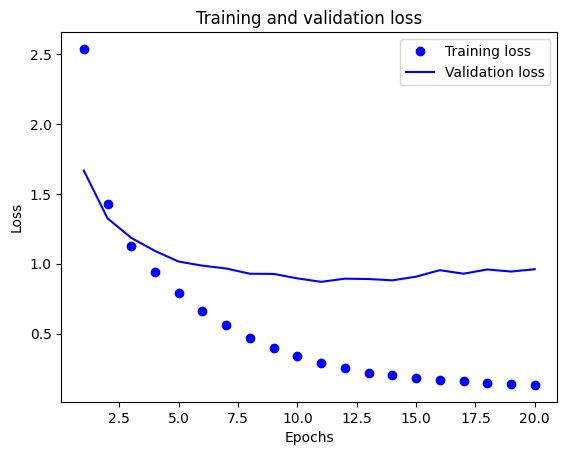

In [19]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

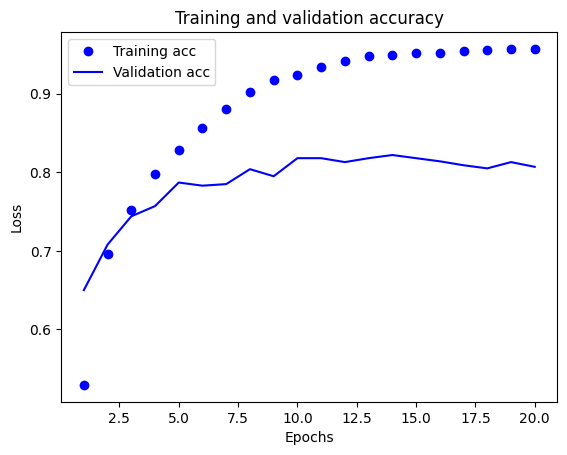

In [20]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems the network starts to overfit after 8 epochs. Let's train a new network from scratch for 8 epochs and then evaluate it on the test set:

In [21]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=8,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.3920 - loss: 3.1859 - val_accuracy: 0.6210 - val_loss: 1.7989
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6631 - loss: 1.6286 - val_accuracy: 0.7040 - val_loss: 1.3655
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7291 - loss: 1.2436 - val_accuracy: 0.7470 - val_loss: 1.1799
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7898 - loss: 0.9858 - val_accuracy: 0.7750 - val_loss: 1.0747
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8194 - loss: 0.8341 - val_accuracy: 0.7850 - val_loss: 0.9953
Epoch 6/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8485 - loss: 0.7114 - val_accuracy: 0.7850 - val_loss: 0.9668
Epoch 7/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8801 - loss: 0.5706 - val_accuracy: 0.8070 - val_loss: 0.9150
Epoch 8/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8989 - loss: 0.4889 - val_accuracy: 0.8060 - val_loss:

Accuracy of 77% is quite reasonable given that we have 46 classes.

In [22]:
results

[0.9599111676216125, 0.7738201022148132]

Our approach achieves an accuracy of ~78%. In a balanced binary classification problem, a purely random classifier would achieve 50% accuracy, but in our case a random baseline is closer to 19%, so our results appear quite good, at least compared to the random baseline:

In [23]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.1918967052537845

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic predictions for all test data:

In [ ]:
predictions = model.predict(x_test) #evaluate on the test set

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Each entry in `predictions` is a vector of length 46:

The coefficients in this vector sum to 1:

In [ ]:
np.sum(predictions[0]) #sum for the first input element in terms of the sum of probabilities for those 46 classes

np.float32(0.9999999)

The largest entry is the predicted class, i.e., the class with the highest probability:

In [ ]:
np.argmax(predictions[0]) #which class is most likely, the index at which we have the maximum value

np.int64(3)

## A different way of handling labels and the loss function

Earlier we mentioned that another way to encode the labels is to convert them into an integer tensor, like this:

In [27]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

The only thing that would change is the choice of the loss function. Our previous loss function, `categorical_crossentropy`, expects the labels to be one-hot encoded. With integer labels, you should use `sparse_categorical_crossentropy`:

In [28]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

This new loss function is still mathematically identical to categorical_crossentropy; it only has a different interface.

## On the importance of having sufficiently large hidden layers

Earlier we mentioned that, since our final outputs are 46-dimensional, we should avoid hidden layers with far fewer than 46 units. Now let's see what happens when we introduce an information bottleneck by using hidden layers that are significantly lower-dimensional than 46, e.g. 4-dimensional.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu')) #example of reducing the middle hidden layer to 4 nodes
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3153 - loss: 3.1309 - val_accuracy: 0.5520 - val_loss: 1.9887
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5951 - loss: 1.8017 - val_accuracy: 0.6300 - val_loss: 1.5662
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6586 - loss: 1.4563 - val_accuracy: 0.6580 - val_loss: 1.4290
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7037 - loss: 1.2270 - val_accuracy: 0.6730 - val_loss: 1.3806
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7208 - loss: 1.1438 - val_accuracy: 0.6760 - val_loss: 1.3611
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7307 - loss: 1.0861 - val_accuracy: 0.6800 - val_loss: 1.3506
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7433 - loss: 1.0136 - val_accuracy: 0.6790 - val_loss: 1.3513
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7611 - loss: 0.9318 - val_accuracy: 0.6880 - val_loss

In [30]:
results = model.evaluate(x_test, one_hot_test_labels)
results

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7097 - loss: 1.7827


[1.8156369924545288, 0.7012466788291931]

Our network now reaches a peak test accuracy of ~71%, a drop of 8%. This drop is mainly due to the fact that we are trying to compress a large amount of information (enough to recover the separating hyperplanes for 46 classes) into an intermediate space that is too low-dimensional. The network can "squeeze" most of the necessary information into these 8-dimensional representations, but not all of it.

## Further experiments

* Try using larger or smaller layers: 32 units, 128 units...

* We used two hidden layers. Now try using only one hidden layer, or three hidden layers.

## Conclusion

Here’s what you should take away from this example:

* If you’re trying to classify data points among N classes, your network should end with a `Dense` layer of size N.
* In single-label, multiclass classification, your network should end with a `softmax` activation so it outputs a probability distribution over the N output classes.
* **Categorical crossentropy** (`categorical_crossentropy`) is almost always the loss function you should use for such problems. It minimizes the distance between the probability distribution produced by the network and the true target distribution.
* There are two ways to handle labels in multiclass classification:
    * Encode labels via "categorical encoding" (also known as one-of-N / one-hot encoding) and use `categorical_crossentropy` as the loss.
    * Encode labels as integers and use `sparse_categorical_crossentropy` as the loss.
* If you need to classify data into a large number of categories, avoid creating "information bottlenecks" in your network by using hidden layers that are too small.